## **Dimensionality reduction**

In several scenarios, you may be dealing with functional data. That is the data could be sampled from a multi-dimensional space, and in some cases the number of dimensions could be very huge and may contain redundant information. Dimensionality reduction is a process used to reduce the number of features (or dimensions) in a dataset while retaining as much relevant information as possible.

Gaussian Processes(GPs) do not scale very well to high-dimensional data. `twinLab` provides the functionality to perform dimensionality reduction on the data, truncate the number of dimensions, and train GPs effectively.

In this Jupyter Notebook you will:

1. [Load and define a CSV file.](#1.-Load-and-define-a-CSV-file)
2. [Define the training parameters for your emulator.](#2.-Define-the-training-parameters-for-your-emulator)
3. [Train your emulator using `emulator.train`.](#3.-Train-your-emulator-using-emulator.train)
4. [Make your predictions using `emulator.predict`.](#4.-Make-your-predictions-using-emulator.predict)
5. [Create a second emulator by adjusting the `output_retained_dimensions`.](#5.-Create-a-second-emulator-by-adjusting-the-output_retained_dimensions)
6. [Plot the predictions and analyse the results.](#6.-Plot-the-predictions-and-analyse-the-results)


Start by importing all the necessary packages you need for this tutorial.


In [17]:
# system imports
import os
from itertools import product

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl

Make sure you set up your API key and other information to be able to use `twinLab`, either through a `.env` file, using `secrets`, or through `tl.set_user`/`tl.set_api_key`.


### **1. Load and define a CSV file**


`twinLab` does offers large example dataset as part of our available example datasets, so we'll be using that primarily for this tutorial. However, you might want to experiment using `twinLab` with your own large dataset, so we have included some optional code to demonstrate how you could go about doing this. First, you'll want to read the train and test DataFrames that `twinLab` expects from their respective `.csv` files that you have stored locally. 

Assuming you have your files saved in your current working directory, let's check what that working directory is to find the filepath to your `.csv` file.


In [2]:
# (Optional) If using your own dataset, uncomment the line below to find the path for your csv file
# path = os.getcwd()

# print(path)

Next, use `pandas` to read your required test and train CSV files, and load them into `pandas DataFrames`. This might look something like:


In [3]:
# (Optional) If using your own dataset, uncomment the line below to load data from a csv file
# my_data = pd.read_csv(path)

For this tutorial, we can explore dimension reduction using an example dataset from `twinLab`. The dataset we're using explores the topic of tritium-desorption in a nuclear reactor, and contains datapoints with 5 input dimensions and 624 output dimensions. This number of output dimensions is huge, and it might be better to train our emulators on truncated outputs for efficient and effective training.


In [4]:
# load example training dataset and grid dataset
df = tl.load_example_dataset("tritium-desorption-small")
df_grid = tl.load_example_dataset("tritium-desorption-temperature-grid")

# View your dataset
display(df)

,E1,E2,E3,n1,n2,y0,y1,y2,y3,y4,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
0,0.726163,1.248766,1.128671,0.002004,0.000307,1.511613e+17,1.626357e+17,1.749599e+17,1.881609e+17,2.022474e+17,...,2.318606e+17,2.304607e+17,2.290609e+17,2.276611e+17,2.262613e+17,2.248615e+17,2.234616e+17,2.220618e+17,2.206620e+17,2.192622e+17
1,0.787837,0.925174,1.226117,0.001564,0.000768,7.621430e+16,8.255297e+16,8.942421e+16,9.684174e+16,1.048160e+17,...,2.728998e+16,2.706896e+16,2.684793e+16,2.662690e+16,2.640587e+16,2.618484e+16,2.596381e+16,2.574279e+16,2.552176e+16,2.530073e+16
2,0.710103,0.902457,1.558539,0.004860,0.000613,2.376907e+17,2.553641e+17,2.743015e+17,2.945655e+17,3.161688e+17,...,2.079730e+16,2.078486e+16,2.077242e+16,2.075998e+16,2.074754e+16,2.073510e+16,2.072265e+16,2.071021e+16,2.069777e+16,2.068533e+16
3,0.757797,1.187059,1.479970,0.002868,0.000841,1.491269e+17,1.609964e+17,1.737868e+17,1.875378e+17,2.022633e+17,...,2.405455e+17,2.382445e+17,2.359435e+17,2.336425e+17,2.313415e+17,2.290405e+17,2.267395e+17,2.244385e+17,2.221375e+17,2.198365e+17
4,0.880510,0.987709,1.305003,0.001307,0.000302,8.396414e+15,9.173453e+15,1.003567e+16,1.097871e+16,1.200347e+16,...,3.434468e+16,3.408240e+16,3.382012e+16,3.355785e+16,3.329557e+16,3.303329e+16,3.277101e+16,3.250873e+16,3.224646e+16,3.198418e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.783867,1.193278,1.320413,0.003886,0.000659,1.345699e+17,1.456865e+17,1.576992e+17,1.706529e+17,1.845647e+17,...,2.099361e+17,2.070631e+17,2.041900e+17,2.013170e+17,1.984440e+17,1.955710e+17,1.926980e+17,1.898249e+17,1.869519e+17,1.840789e+17
396,0.922680,1.079673,1.221674,0.003768,0.000976,5.668893e+15,6.290050e+15,6.911207e+15,7.596330e+15,8.344831e+15,...,1.136794e+17,1.125222e+17,1.113649e+17,1.102076e+17,1.090504e+17,1.078931e+17,1.067358e+17,1.055786e+17,1.044213e+17,1.032640e+17
397,0.851955,1.066713,1.391201,0.002094,0.000136,2.624759e+16,2.862085e+16,3.122200e+16,3.405309e+16,3.712017e+16,...,4.119450e+16,4.079302e+16,4.039155e+16,3.999007e+16,3.958860e+16,3.918712e+16,3.878565e+16,3.838417e+16,3.798270e+16,3.758122e+16
398,0.901088,1.227554,1.713012,0.001436,0.000137,5.259842e+15,5.754444e+15,6.307820e+15,6.915794e+15,7.578222e+15,...,2.415848e+17,2.377526e+17,2.339204e+17,2.300882e+17,2.262560e+17,2.224238e+17,2.185916e+17,2.147594e+17,2.109272e+17,2.072690e+17


The output columns contain values that are of a very high order (up to 1e+18). This can cause numerical instability when training the dimensionality reduction model. To avoid this you can divide all the output values by 1e+18, making them closer to an order of 1 and causing less instability when predicting your results.

In [5]:
# Define input and output columns
input_columns = ["E1", "E2", "E3", "n1", "n2"]
output_columns = [
    f"y{i}" for i in range(0, df.shape[1] - len(input_columns))
]  # Loops through output column headers

# Divide output data by 1e+18
df[output_columns] = df[output_columns].div(1e18)

Define your train and test data.


In [6]:
# Define test and train size
train_len = 350
eval_len = len(df) - train_len

# Define train and test data
df_train = df[:train_len]
df_eval = df[train_len : train_len + eval_len]

Define your input and output columns. As there are a large number of output columns, you can use a list comprehension to loop through each of the output column headers.


Define a `Dataset` object and upload it to the `twinLab` cloud.


In [7]:
# Define the name of the dataset
dataset_id = "Tritium_Desorption_Data"

# Intialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset
dataset.upload(df_train, verbose=True)

Dataframe is uploading.
Summarising dataset
Dataset summary created and saved.


### **2. Define the training parameters for your emulator**

In `twinlab`, dimensionality reduction is implemented in the form of truncated Singular Value Decomposition (tSVD), and is accessible in two ways.

It can be performed by specifying the number of dimensions you wish to truncate the data to, using `input_retained_dimensions` for inputs and `output_retained_dimensions` for outputs. This can also be specified through the amount of variance to be explained by the data after truncation through `input_explained_variance` for inputs and `output_explained_variance` for outputs.

These parameters are part of the `TrainParams` object, and can then be further passed to the training function `Emulator.train`.


#### Explained Variance

In this method, you specify the amount of variance to be explained by the retained dimensions. First, you need to set up the parameters and initialise the emulator.


In [8]:
# Create TrainParams object with explained variance
explained_variance_params = tl.TrainParams(
    train_test_ratio=0.80,  # Specifies ratio of train data to test data (0.80 = 80% train data and 20% test data)
    estimator="gaussian_process_regression",  # Specifies type of estimation
    input_explained_variance=0.95,
    output_explained_variance=0.90,
)

# Initialise emulator
emulator_id = "TritiumDesorptionGP-ExplainedVariance"  # Specifies type of emulator
emulator = tl.Emulator(id=emulator_id)

Next, you can train your emulator.


In [9]:
# (Optional) Train the emulator using the explained variance (uncomment code below to use)
# emulator.train(
#     dataset=dataset,
#     inputs=input_columns,
#     outputs=output_columns,
#     params=params,
#     verbose=True,
# )

#### Retained Dimensions

In this method, you explicitly specify the number of dimensions to retain. One can decompose the inputs, outputs, or both in the same `Emulator`. The parameters below will sets the output dimensions to **2**.


In [10]:
# Initialise emulator
emulator_id = "TritiumDesorptionGP1"  # Specifies type of emulator
emulator1 = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
params = tl.TrainParams(
    train_test_ratio=0.80,  # Specifies ratio of train data to test data (0.80 = 80% train data and 20% test data)
    estimator="gaussian_process_regression",  # Specifies type of estimation
    output_retained_dimensions=2,  # Specifies the number of output dimensions you wish to truncate the data to
)

### **3. Train your emulator using `emulator.train`**

Set the parameters (`params`) to `params` defined above. This will train the emulator by truncating the the number of output dimensions to **2** (from 624).


In [11]:
emulator1.train(
    dataset=dataset,
    inputs=input_columns,
    outputs=output_columns,
    params=params,
    verbose=True,
)

Emulator 'TritiumDesorptionGP1' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:09: Job status: processing
0:00:12: Job status: processing
0:00:15: Job status: processing
0:00:18: Job status: processing
0:00:21: Job status: processing
0:00:25: Job status: success
Training of emulator TritiumDesorptionGP1 is complete!


### **4. Make your predictions using `emulator.predict`**

Use test data (`df_eval`) to predict the results.


In [12]:
predictions = emulator1.predict(df_eval[input_columns])
result_df = pd.concat([predictions[0], predictions[1]], axis=1)
df_mean1, df_std1 = (
    result_df.iloc[
        :, : len(output_columns)
    ],  # define first section as the mean predictions
    result_df.iloc[
        :, len(output_columns) :
    ],  # define second section as the standard deviation predictions
)

Job predict process ID: predict-thin-pinto-cent
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:09: Job status: processing
0:00:12: Job status: processing
0:00:15: Job status: processing
0:00:18: Job status: processing
0:00:21: Job status: processing
0:00:25: Job status: processing
0:00:29: Job status: processing
0:00:34: Job status: success
Mean predictions:
          y0        y1        y2        y3        y4        y5        y6  \
0   0.046534  0.050301  0.054371  0.058755  0.063459  0.068469  0.073785   
1   0.038614  0.041832  0.045324  0.049098  0.053160  0.057496  0.062109   
2   0.171483  0.185254  0.200114  0.216108  0.233255  0.251502  0.270852   
3   0.076626  0.082785  0.089433  0.096588  0.104260  0.112425  0.121084   
4  -0.007474 -0.007938 -0.008415 -0.008911 -0.009424 -0.009954 -0.010500   
5   0.077476  0.083782  0.090600  0.097950  0.105840  0.114247  0

### **5. Create a second emulator by adjusting the `output_retained_dimensions`**

Now try and train a new emulator with slightly increased number of dimensions, but still significantly less than the original number of output dimensions. Train a new emulator with only **six** dimensions. First, set up the new emulator and parameters required for six dimensions:


In [13]:
# Initialise emulator
emulator_id = "TritiumDesorptionGP2"

emulator2 = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
params = tl.TrainParams(
    train_test_ratio=0.80,
    estimator="gaussian_process_regression",
    output_retained_dimensions=6,
)

Then train the emulator and run predict:


In [14]:
# Train the emulator using the train method
emulator2.train(
    dataset=dataset,
    inputs=input_columns,
    outputs=output_columns,
    params=params,
    verbose=True,
)

# Use test data to predict the results
predictions2 = emulator2.predict(df_eval[input_columns])
result_df2 = pd.concat([predictions2[0], predictions2[1]], axis=1)
df_mean2, df_std2 = (
    result_df2.iloc[:, : len(output_columns)],
    result_df2.iloc[:, len(output_columns) :],
)

Emulator 'TritiumDesorptionGP2' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:09: Job status: processing
0:00:12: Job status: processing
0:00:15: Job status: processing
0:00:18: Job status: processing
0:00:21: Job status: processing
0:00:25: Job status: processing
0:00:29: Job status: processing
0:00:34: Job status: processing
0:00:39: Job status: success
Training of emulator TritiumDesorptionGP2 is complete!
Job predict process ID: predict-succulent-scratch-vase
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:09: Job status: processing
0:00:12: Job status: processing
0:00:15: Job status: processing
0:00:18: Job status: processing
0:00:21: Job status: success
Mean predictions:
          y0        y1        y2        y3        y4      

### **6. Plot the predictions and analyse the results**


To plot the predictions of the two trained emulators with different output dimensions--alongside the true values from the test data--you can define a function `plot_predictions`.


In [15]:
def plot_predictions(df_mean1, df_mean2, df_std1, df_std2, df_grid, output_columns):

    # Parameters for plot
    error_inflation_factor = 1.0  # Factor to multiply error by for plotting
    y_fac = 18  # Factor to divide y by for plotting [log10]
    alpha = 0.5  # Plot opacity

    # Define data
    df_mean = [df_mean1, df_mean2]
    df_std = [df_std1, df_std2]

    # Define labels and colours for test, emulator 1 and emulator 2 data
    label = ["Test Data", "Emulator 1", "Emulator 2"]
    color = ["black", "red", "green"]

    # Plot results
    grid = df_grid.iloc[:, 0]
    fig, axs = plt.subplots(1, 5, figsize=(30, 5))

    # Model predictions
    for example in range(5):
        # Plot test data
        eval = df_eval[output_columns].iloc[example] / 10**y_fac
        axs[example].plot(
            grid,
            eval,
            color=color[0],
            alpha=alpha,
            label=label[0] if example == 0 else None,
        )
        for i, emul in enumerate([1, 2]):
            # Plot uncertainty bands
            for j, emul2 in enumerate([1, 2]):
                mean = df_mean[j][output_columns].iloc[example] / 10**y_fac
                err = (
                    error_inflation_factor
                    * df_std[j][output_columns].iloc[example]
                    / 10**y_fac
                )
                axs[example].fill_between(
                    grid,
                    mean - emul * err,
                    mean + emul * err,
                    color=color[emul2],
                    alpha=alpha / (emul),
                    lw=0.0,
                    label=label[emul] if (i == 0) and (example == 0) else None,
                )
            # Plot mean
            mean = df_mean[i][output_columns].iloc[example] / 10**y_fac
            axs[example].plot(
                grid,
                mean,
                color=color[emul],
                label=label[emul] if (example == 0) else None,
                alpha=alpha,
            )
        axs[example].set_xlabel(r"Temperature [K]")
        axs[example].set_ylabel(
            rf"Desorption rate [$10^{{{y_fac}}}$ $m^{{{-2}}}$ $s^{{{-1}}}$]"
        )
        axs[example].legend(label)
    plt.show()

Now you can execute this plotting function and visualise the two emulators, with two different dimension reductions performed on them:


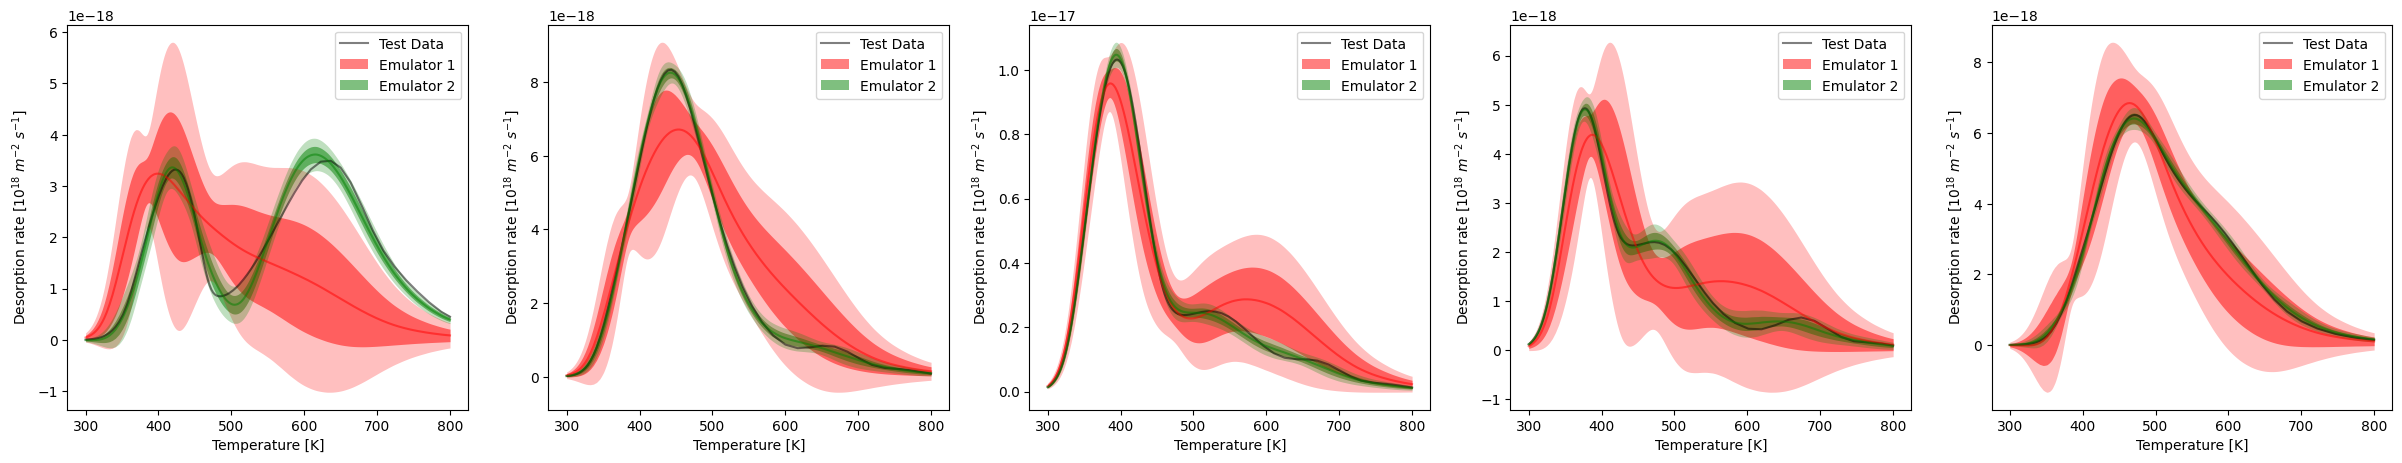

In [16]:
plot_predictions(df_mean1, df_mean2, df_std1, df_std2, df_grid, output_columns)

#### Model 1

It can be observed that the first emulator, trained with very low output dimensions, only 2 of 624, fails to approximate the data properly. This can be attributed to the massive truncation of the output dimensions.

#### Model 2

The second emulator was trained on 6 output dimensions. This is definitely more than the first emulator but is still significantly lower than the original number of dimensions. With this emulator, you seem to have struck the right balance, as you can see even by how the emulator fits to the test data more accurately.

As you can see, your predictions are very accurate! You reduced the number of output dimensions from 624 to 6 and still managed to train a very good surrogate of the underlying functional data.

This shows how you can achieve accurate emulators whilst significantly reducing your computation time. The ease with which dimensionality reduction can be implemented in `twinLab`, by simply specifying parameters such as `input_retained_dimensions` and `output_retained_dimensions` or `input_explained_variance` and `output_explained_variance` for outputs, demonstrates the efficiency and power of this tool. By using `twinLab`, you can leverage advanced techniques to optimize your engineering workflows, leading to better performance and faster results.
